In [1]:
!pip install pandas numpy matplotlib seaborn scikit-learn openpyxl





[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

print("Libraries ready")


Libraries ready


In [4]:
import pandas as pd
import numpy as np
from datetime import timedelta
#1) Loading and leveling the base
#file
file_path = "../data/online_retail.xlsx.csv"

# Csv
df = pd.read_csv(file_path, encoding="ISO-8859-1")


print(df.shape)
df.head()


(536350, 8)


,TransactionNo,Date,ProductNo,ProductName,Price,Quantity,CustomerNo,Country
0,581482,12/9/2019,22485,Set Of 2 Wooden Market Crates,21.47,12,17490.0,United Kingdom
1,581475,12/9/2019,22596,Christmas Star Wish List Chalkboard,10.65,36,13069.0,United Kingdom
2,581475,12/9/2019,23235,Storage Tin Vintage Leaf,11.53,12,13069.0,United Kingdom
3,581475,12/9/2019,23272,Tree T-Light Holder Willie Winkie,10.65,12,13069.0,United Kingdom
4,581475,12/9/2019,23239,Set Of 4 Knick Knack Tins Poppies,11.94,6,13069.0,United Kingdom


In [5]:
import pandas as pd
from datetime import timedelta
#2) Type conversion and cleaning
# df = pd.read_csv("../data/online_retail.xlsx.csv", encoding="ISO-8859-1")

#  Case-insensitive
df.columns = [c.strip().lower().replace(" ", "") for c in df.columns]
print(df.columns.tolist())


['transactionno', 'date', 'productno', 'productname', 'price', 'quantity', 'customerno', 'country']


In [6]:
# Convert dates and numbers
df["date"]      = pd.to_datetime(df["date"], errors="coerce")
df["quantity"]  = pd.to_numeric(df["quantity"], errors="coerce")
df["price"]     = pd.to_numeric(df["price"],    errors="coerce")

# Remove critical empty rows
df = df.dropna(subset=["transactionno","customerno","date","quantity","price"])

# Remove invalid values
df = df[(df["quantity"] > 0) & (df["price"] > 0)]

# Amount per row
df["totalprice"] = df["quantity"] * df["price"]

print("✅ cleaned shape:", df.shape)
df.head()


✅ cleaned shape: (527764, 9)


,transactionno,date,productno,productname,price,quantity,customerno,country,totalprice
0,581482,2019-12-09,22485,Set Of 2 Wooden Market Crates,21.47,12,17490.0,United Kingdom,257.64
1,581475,2019-12-09,22596,Christmas Star Wish List Chalkboard,10.65,36,13069.0,United Kingdom,383.40
2,581475,2019-12-09,23235,Storage Tin Vintage Leaf,11.53,12,13069.0,United Kingdom,138.36
3,581475,2019-12-09,23272,Tree T-Light Holder Willie Winkie,10.65,12,13069.0,United Kingdom,127.80
4,581475,2019-12-09,23239,Set Of 4 Knick Knack Tins Poppies,11.94,6,13069.0,United Kingdom,71.64


In [7]:
#3) Create RFM table with own columns

snapshot_date = df["date"].max() + timedelta(days=1)

rfm = (df.groupby("customerno")
         .agg(
             recency = ("date",        lambda x: (snapshot_date - x.max()).days),
             frequency = ("transactionno", "nunique"),
             monetary  = ("totalprice", "sum")
         )
         .reset_index())

rfm.head(), rfm.describe()


(   customerno  recency  frequency  monetary
 0     12004.0      228          1   1509.60
 1     12006.0      219          1     24.76
 2     12008.0      277          1   5689.57
 3     12013.0      360          1     69.96
 4     12024.0      177          1    149.52,
          customerno      recency    frequency      monetary
 count   4718.000000  4718.000000  4718.000000  4.718000e+03
 mean   15245.855235    96.992794     4.194362  1.334589e+04
 std     1741.805611   101.758271     7.396101  5.439743e+04
 min    12004.000000     1.000000     1.000000  5.970000e+00
 25%    13742.250000    19.000000     1.000000  1.838447e+03
 50%    15249.500000    54.000000     2.000000  4.828470e+03
 75%    16746.750000   156.750000     5.000000  1.190628e+04
 max    18287.000000   374.000000   207.000000  2.112282e+06)

In [8]:
#save output (for own)

df.to_csv("../data/online_retail_clean.csv", index=False)
rfm.to_csv("../reports/rfm_table.csv", index=False)
print("aved: data/online_retail_clean.csv  &  reports/rfm_table.csv")


aved: data/online_retail_clean.csv  &  reports/rfm_table.csv


In [8]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Appearance for charts
sns.set(style="whitegrid", palette="pastel", font_scale=1.1)


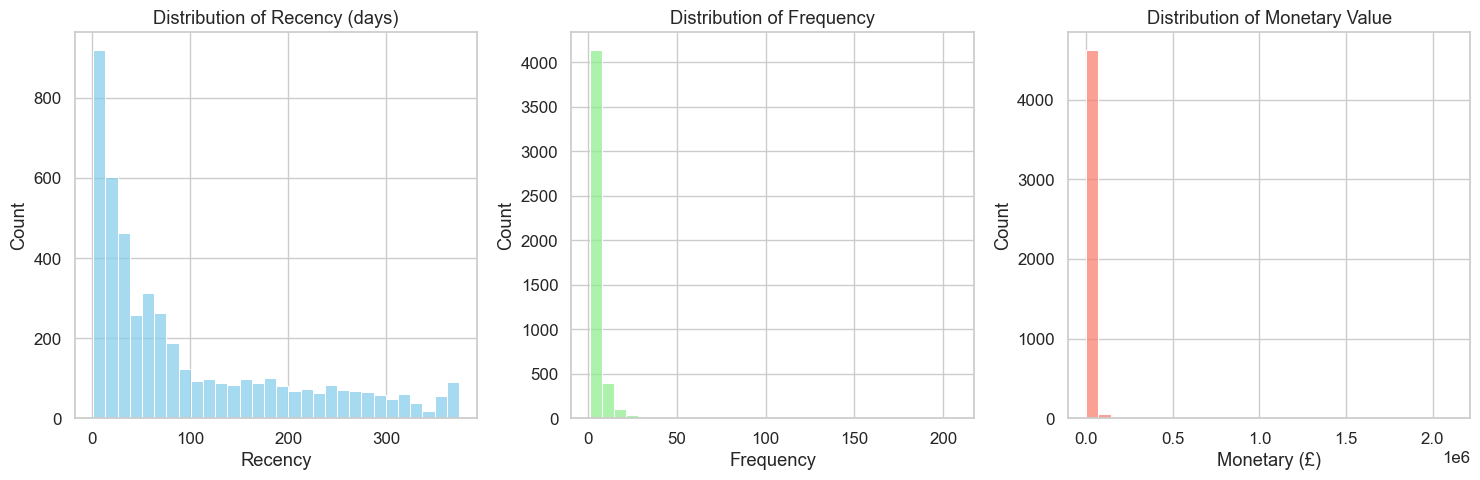

In [9]:
#1) Distribution (Recency Frequency Monetary)
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

sns.histplot(rfm["recency"], bins=30, color="skyblue", ax=axes[0])
axes[0].set_title("Distribution of Recency (days)")
axes[0].set_xlabel("Recency")

sns.histplot(rfm["frequency"], bins=30, color="lightgreen", ax=axes[1])
axes[1].set_title("Distribution of Frequency")
axes[1].set_xlabel("Frequency")

sns.histplot(rfm["monetary"], bins=30, color="salmon", ax=axes[2])
axes[2].set_title("Distribution of Monetary Value")
axes[2].set_xlabel("Monetary (£)")

plt.tight_layout()
plt.show()


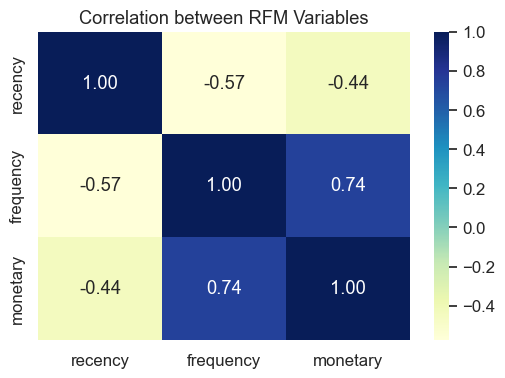

In [10]:
#2)the correlation between R/F/M

plt.figure(figsize=(6,4))
sns.heatmap(rfm[["recency","frequency","monetary"]].corr(method="spearman"), annot=True, cmap="YlGnBu", fmt=".2f")
plt.title("Correlation between RFM Variables")
plt.show()


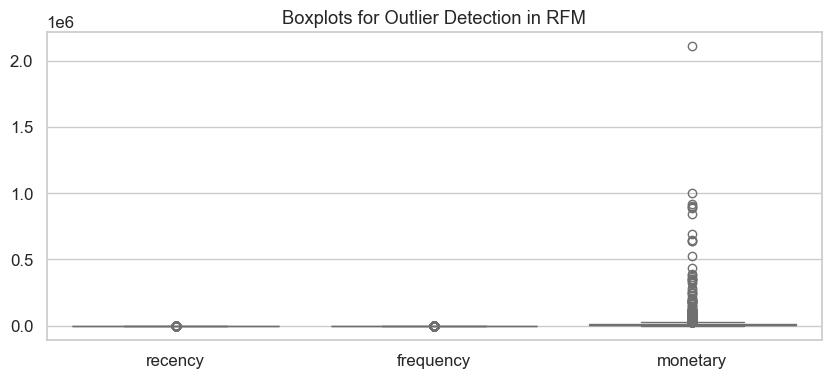

In [11]:
#Outliers
plt.figure(figsize=(10,4))
sns.boxplot(data=rfm[["recency","frequency","monetary"]])
plt.title("Boxplots for Outlier Detection in RFM")
plt.show()


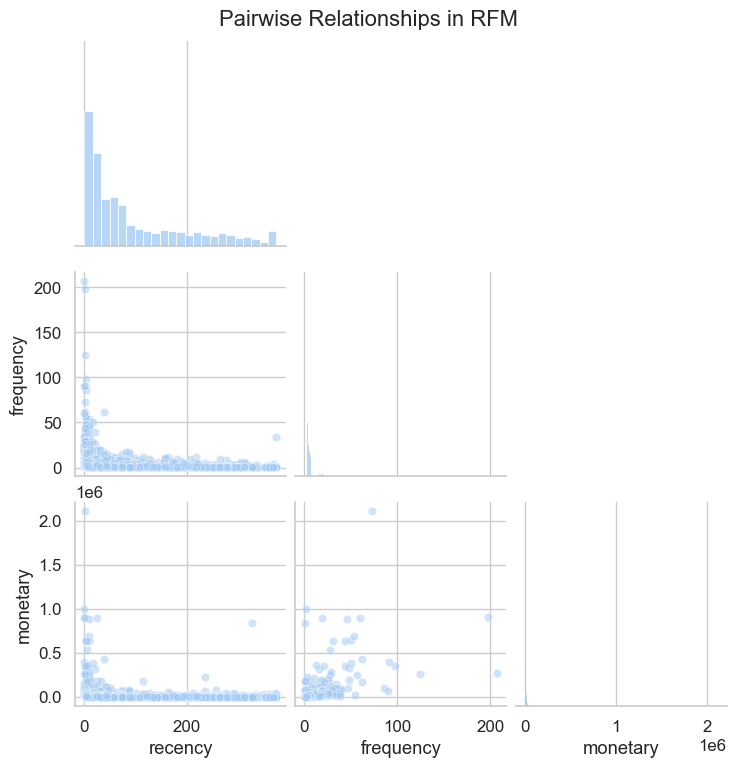

In [12]:
#Scatter plots
sns.pairplot(rfm, vars=["recency","frequency","monetary"], corner=True, diag_kind="hist", plot_kws={"alpha":0.5})
plt.suptitle("Pairwise Relationships in RFM", y=1.02)
plt.show()


In [13]:
fig.savefig("../reports/rfm_distributions.png")
plt.close()


In [ ]:
#Because of the strong skewness and large value ranges observed in the RFM variables,
#it is now necessary to apply data transformation and scaling before performing clustering.
#K-Means is highly sensitive to differences in scale, so transforming and normalizing
#the data ensures that each variable contributes equally to the distance calculations.

#Phase 1: Data Preparation & EDA

#Data Cleaning

#Construction of RFM Variables

#Distribution and Correlation Investigation
